In [51]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [54]:
train_path="/content/drive/MyDrive/final_dataset/train"
test_path="/content/drive/MyDrive/final_dataset/test"
val_path="/content/drive/MyDrive/final_dataset/validation"

In [55]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [56]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)


In [57]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)




In [58]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)


In [59]:
train_x.shape,test_x.shape,val_x.shape

((1536, 224, 224, 3), (480, 224, 224, 3), (384, 224, 224, 3))

In [60]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1536 images belonging to 3 classes.
Found 480 images belonging to 3 classes.
Found 384 images belonging to 3 classes.


In [62]:
training_set.class_indices

{'jeans': 0, 'sarees': 1, 'trousers': 2}

In [63]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [64]:
train_y.shape,test_y.shape,val_y.shape


((1536,), (480,), (384,))

In [65]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [66]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False


In [67]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

In [68]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [69]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [70]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [74]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=20,
  callbacks=[early_stop],
  batch_size=64,shuffle=True)


Epoch 1/20
24/24 [==============================] - 34s 760ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 11.3093 - val_accuracy: 0.3333
Epoch 2/20
24/24 [==============================] - 15s 651ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 11.3287 - val_accuracy: 0.3333
Epoch 3/20
24/24 [==============================] - 15s 651ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 11.3461 - val_accuracy: 0.3333
Epoch 4/20
24/24 [==============================] - 16s 653ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 11.3648 - val_accuracy: 0.3333
Epoch 5/20
24/24 [==============================] - 16s 654ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 11.3819 - val_accuracy: 0.3333
Epoch 6/20
24/24 [==============================] - 16s 655ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 11.4014 - val_accuracy: 0.3333
Epoch 00006: early stopping


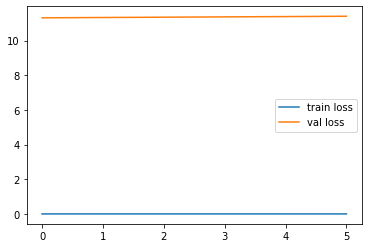

In [75]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()


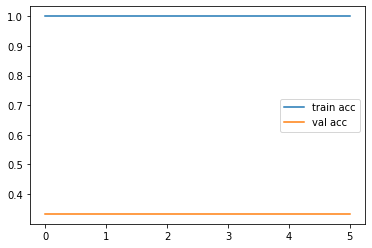

In [76]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()


In [81]:
model.evaluate(test_x,test_y,batch_size=32)



15/15 [==============================] - 4s 267ms/step - loss: 14.2433 - accuracy: 0.0000e+00


[14.243306159973145, 0.0]

In [82]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np


In [83]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [84]:
accuracy_score(y_pred,test_y)


0.0